# First Run Tutorial

In [1]:
# Import the mindaffectBCI decoder and other required modules. 
%load_ext autoreload
%autoreload 2
%gui qt
import mindaffectBCI.decoder
from multiprocessing import Process
from time import sleep

System Architecture
--
The basic architecture of a mindaffectBCI is illustrated here.
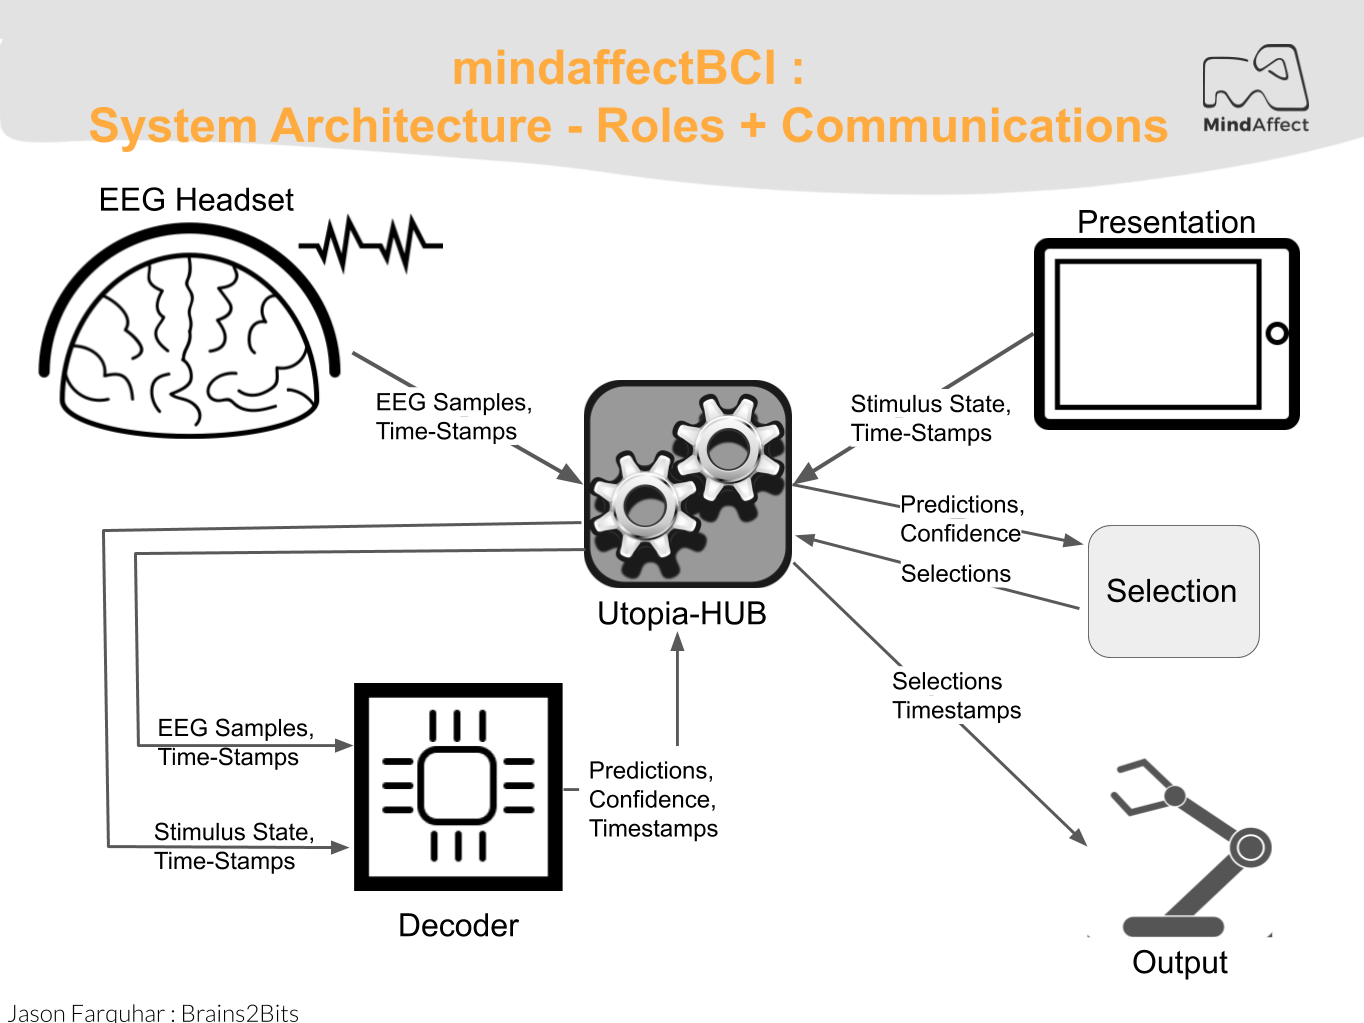

To actually run the BCI we need to start each of these components:

- UtopiaHub: This component is the central server which coordinates all the other pieces, and saves the data for offline analysis.

- Acquisation: This component talks to the *EEG Headset* and streams the data to the Hub

- Decoder: This component analysis the EEG data to fit the subject specific model and generate predictions

- Presentation: This component presents the User-Interface to the user, including any BCI specific stimuli which need to be presented. It also selects outputs when the BCI is sufficiently confident and generates the appropriate output


First, we start the UtopiaHub by runing the following code block:

In [2]:
#--------------------------- HUB ------------------------------
# start the utopia-hub process
from mindaffectBCI.decoder import startUtopiaHub
hub = Process(target=startUtopiaHub.run, daemon=True)
hub.start()

## ACQUISITION 

Now that the hub is running we want to establish a connection between the amplifier and the hub to stream the EEG data.
To achieve this the [Brainflow](https://brainflow.ai/) library is used. The brainflow driver has to be initialized with input parameters that depend on the amplifier in use: (Consult the [Brainflow docs](https://brainflow.readthedocs.io/en/stable/SupportedBoards.html) for a complete list of amplifiers supported by brainflow but currently untested with the MindAffect BCI.)

|**Board** | ```board_id```|```serial_port```|```ip_address```|```ip_port```| 
|:-----------|:---------------|:-----------------|:----------------|:-------------|  
|Ganglion  | 1             |dongle serial port(COM3, /dev/ttyUSB0...)| - | - |
|Ganglion + WiFi Shield|4 |          -            |WIFI Shield IP(default 192.168.4.1)|any local port which is free|
|Cyton     | 0             |dongle serial port(COM3, /dev/ttyUSB0...)| -| -|
|Cyton + Wifi Shield|5|-|WIFI Shield IP(default 192.168.4.1)|any local port which is free|

When using either the OpenBCI Ganglion or Cyton with an USB-dongle we have to pass the ```serial_port``` argument, to find the serial port in use by your amplifier follow the following instructions: 

### On Mac:
1. Open a Terminal session
2. Type: `ls /dev/cu.*`, and look for something like `/dev/cu.usbmodem1` (or similar):

    ```
    $ ls /dev/cu.*
    /dev/cu.Bluetooth-Modem		/dev/cu.iPhone-WirelessiAP
    /dev/cu.Bluetooth-PDA-Sync	/dev/cu.usbserial
    /dev/cu.usbmodem1
    ```

    Then, `serial_port` should be defined as  `"serial_port":"dev/cu.your_com_name"`

### On Windows:

1. Open Device Manager and unfold Ports(COM&LPT), the com port number is shown behind your used bluetooth adapter. 
    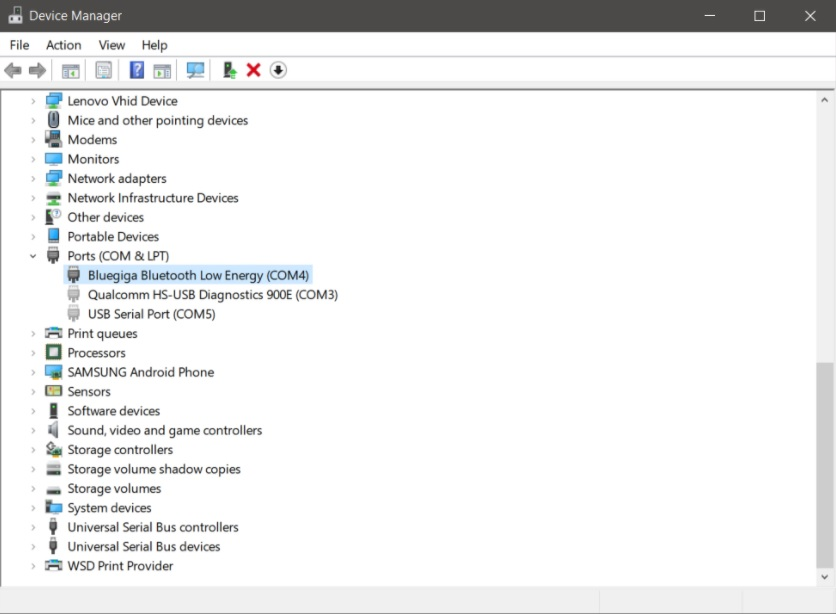
    Then, `serial_port` should be defined as  `"serial_port":"COM_X_"`

The code below shows the `acq_args` for the Ganglion, change the arguments for the board in use and run the code block to start the acquisition process.

In [3]:
# start the ganglion acquisation process
# Using brainflow for the acquisation driver.  
#  the brainflowargs are kwargs passed to BrainFlowInputParams
#  so change the board_id and other args to use other boards
from mindaffectBCI.examples.acquisation import utopia_brainflow
acq_args =dict(board_id=1, serial_port='com4') # connect to the ganglion
acquisation = Process(target=utopia_brainflow.run, kwargs=acq_args, daemon=True)
acquisation.start()
# wait for driver to startup -- N.B. NEEDED!!
sleep(1)

## N.B. Only use this cell if you just want to test with a *fake* eeg stream

In [4]:
# start a fake-data stream
# with 4-channels running at 200Hz
from mindaffectBCI.examples.acquisation import utopia_fakedata
acq_args=dict(host='localhost', nch=4, fs=200)
acquisation = Process(target=utopia_fakedata.run, kwargs=acq_args, daemon=True)
acquisation.start()

## DECODER 

The decoder is the core of the BCI at it takes in the raw EEG and stimulus information and generates predictions about which stimulus the user is attending to. Generating these predictions relies on signal processing and machine learning techniques to learn the best decoding parameters for each user. However, ensuring best performance means the settings for the decoder should be appropriate for the particular BCI being used. The default decoder parameters are shown in the code below, and are setup for a noisetagging BCI.

In [5]:
# start the decoder process, wih default args for noise-tagging
from mindaffectBCI.decoder import decoder
decoder = Process(target=decoder.mainloop, kwargs=dict(
        stopband=[[45,65],[0,3],[25,-1]],
        out_fs=100,
        evtlabs=["re","fe"],
        tau_ms=450,
        calplots=True,
        predplots=False
    ), daemon=True)
decoder.start()

The key parameters here are:

- `stopband`: this is a [temporal filter](https://en.wikipedia.org/wiki/Filter_(signal_processing)) which is applied as a pre-processing step to the incomming data.  This is important to remove external noise so the decoder can focus on the target brain signals.   Here the filter is specified as a list of [band stop](https://en.wikipedia.org/wiki/Band-stop_filter) filters, which specify which signal frequencies should be suppressed, (where, in classic python fashion -1 indicates the max-possible frequency).  Thus, in this example all frequencies below 3Hz and above 25Hz are removed.

- `out_fs`: this specifies the post-filtering sampling rate of the data.  This reduces the amount of data which will be processed by the rest of the decoder.  Thus, in this example after filtering the data is re-sampled to 80Hz.  (Note: to avoid []() out_fs should be greater than 2x the maximum frequency passed by the stop-band).

- `evtlabs`: this specifies the stimulus properties (or event labels) the decoder will try to predict from the brain responses.  The input to the decoder (and the brain) is the raw-stimulus intensity (i.e. it's brightness, or loudness).  However, depending on the task the user is performing, the brain may *not* respond directly to the brightness, but some other property of the stimulus.  For example, in the classic [P300 'odd-ball' BCI](https://en.wikipedia.org/wiki/P300_(neuroscience)#Applications), the brain responds not to the raw intensity, but to the start of *surprising* stimuli.  The design of the P300 matrix-speller BCI means this response happens when the users choosen output 'flashes', or gets bright.  Thus, in the P300 BCI the brain responses to the [rising-edge](https://en.wikipedia.org/wiki/Signal_edge) of the stimulus intensity.   Knowing, exactly what stimulus property the brain is responding to is a well studied neuroscientific research question, with examples including, stimulus-onset (a.k.a. rising-edge, or 're'), stimulus-offset (a.k.a. falling-edge, or 'fe'), stimulus intensity ('flash'), stimulus-duration etc.  Getting the right stimulus-coding is critical for BCI peformance, see [`stim2event.py`](mindaffectBCI/decoder/stim2event.py) for more information on supported event types.

- `tau_ms`: this specifies the maximum duration of the expected brain response to a triggering event in *milliseconds*.  As with the trigger type, the length of the brian response to a triggering event depends on the type of response expected.  For example for the P300 the response is between 300 and 600 ms after the trigger, whereas for a VEP the response is between 100 and 400 ms.   Ideally, the response window should be as small as possible, so the learning system only gets the brain response, and not a lot of non-response containing noise which could lead the machine learning component to [overfitt](https://en.wikipedia.org/wiki/Overfitting).


## PRESENTATION 

Before launching the presentation component we first make sure that the Hub, Acquisation, and Decoder components are running:

In [6]:
# check all is running?
print("Hub running {}".format(hub.is_alive()))
print("Acquisation running {}".format(acquisation.is_alive()))
print("Decoder running {}".format(decoder.is_alive()))

Hub running False
Acquisation running True
Decoder running True


If not, try running the corrspondig codeblock of the inactive component before continuing.  

### Creating the Stimulus  
By default we use the mindaffect NoiseTagging style stimulus with a 25-symbol letter matrix for presentation.  You can easily try different types of stimulus and selection matrices by modifying the `symbols` and `stimfile`arguments. Where:
* _symbols_ : can either by a list-of-lists of the actual text to show, for example for a 2x2 grid of sentences:

In [7]:
 symbols=[["I'm happy","I'm sad"], ["I want to play","I want to sleep"]],

or a file from which to load the set of symbols as a *comma-separated* list of strings like the file [symbols.txt](https://github.com/mindaffect/pymindaffectBCI/blob/open_source/mindaffectBCI/examples/presentation/symbols.txt).

In [8]:
symbols="symbols.txt" 

* _stimfile_ : is a file which contains the stimulus-code to display.  This can either be a text-file with a matrix specified with a white-space separated line per output or a png with the stimulus with outputs in 'x' and time in 'y'. This is what the _codebook_ for the noisetag looks like where symbols are left to right and time is top to bottom.
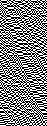



### Running the Stimulus
The UI with the desired presentation stimuli can be launched by running the code below:

In [ ]:
# run the presentation, with our matrix and default parameters for a noise tag
from mindaffectBCI.examples.presentation import selectionMatrix
selectionMatrix.run(symbols=symbols, stimfile="mgold_65_6532_psk_60hz.png")

Now that the system is up and running, you can go through the following steps to use the BCI!

1. EEG headset Setup

    Prepare a headset such that it follows the [MindAffect headset layout.pdf](https://github.com/mindaffect/Headset/blob/master/MindAffect%20headset%20layout.pdf) in our Headset repository or prepare the headset delivered with your kit by following [MindAffect headset setup.pdf](https://github.com/mindaffect/Headset/raw/master/MindAffect%20Headset%20Set%20up%20instructions.pdf)


2. Signal Quality

    Check the signal quality by pressing 0 in the main menu. Try to adjust the headset until all electrodes are green, or noise to signal ratio is below 5. 
    You can try to improve the signal for an electrode by pressing it firmly into your head. After releasing pressure, wait a few seconds to see if the signal improves. If not, remove the electrode, and apply more water to the sponge. The sponges should feel wet on your scalp.
    If  the noise to signal ratio does not improve by adjusting the headset, try to distance yourself from power outlets and other electronics.


3. Calibration

    Start calibration by pressing 1 in the main menu. Continue to follow the on-screen instructions.


4. Feedback

    You are now ready to try out the BCI by either selecting Copy-spelling (2) or Free-spelling (1)!
    
**Struggeling to get the system to work? Consult our** [FAQ](https://mindaffect-bci.readthedocs.io/en/latest/FAQ.html) **section for info on how to improve calibration accuracy, prediction performance, and more!**


## Do you not want to run this notebook everytime when using the BCI?
Simply run it from your command prompt:    
  
``` python3 -m mindaffectBCI.online_bci```  
   
Or with one of the 3 provided configuration files:  
  
``` python3 -m mindaffectBCI.online_bci --config_file noisetag_bci.json ```  

 * [noisetag.json](https://github.com/mindaffect/pymindaffectBCI/tree/open_source/mindaffectBCI/noisetag_bci.json) : example for a [noise-tagging](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133797) (or c-VEP) BCI (Default)
 * [rc5x5.json](https://github.com/mindaffect/pymindaffectBCI/tree/open_source/mindaffectBCI/rc5x5_bci.json) : example for a classic visual P300 odd-ball type BCI with row-column stimulus.
 * [ssvep.json](https://github.com/mindaffect/pymindaffectBCI/tree/open_source/mindaffectBCI/ssvep_bci.json) : example for a classic [steady-state-visual-response](https://arxiv.org/abs/2002.01171) BCI.
 
 



## SHUTDOWN 


In [9]:
# shutdown the background processes
decoder.terminate()
hub.terminate()
acquisation.terminate()